In [ ]:
import time 
import plot
import torch

In [ ]:
torch.manual_seed(1) # set random number generator seed (allows to repeat results)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') # set computing device (CPU or GPU)
torch.set_default_dtype(torch.float32) # set floating-point precision

In [ ]:
data = torch.load('data.pt', map_location=device) # load data
inputs = data["young_modulus"].view(128, 1, 64, 64, 64) # extract inputs
outputs = data["stress"].select(5, 0).select(1, 0).view(128, 1, 64, 64, 64) # extract outputs

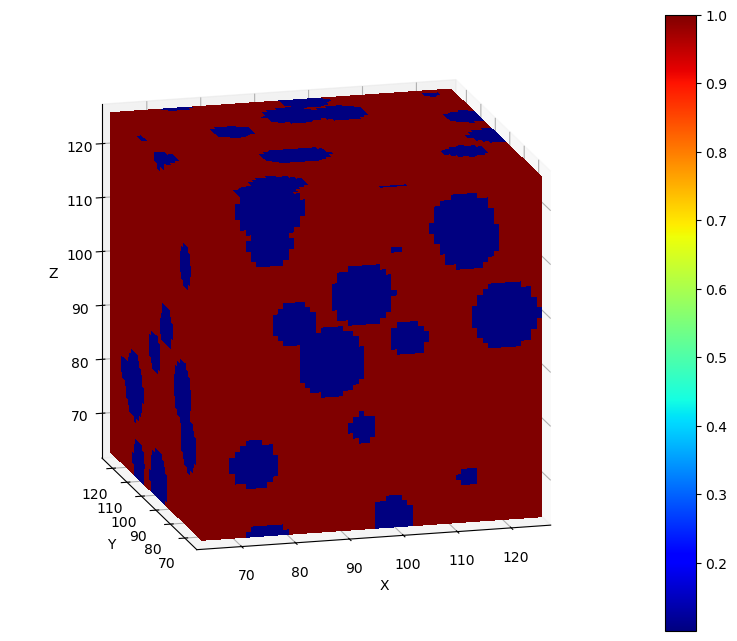

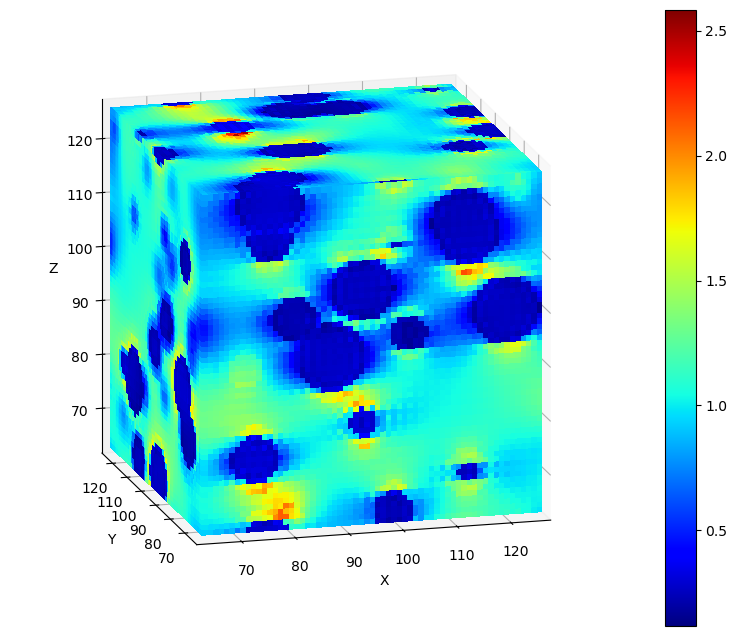

In [ ]:
x, y, z = torch.arange(64), torch.arange(64), torch.arange(64) # create grid
plot.volume(x, y, z, inputs[0, 0], title="True stress") # plot true stress
plot.volume(x, y, z, outputs[0, 0], title="Young's modulus") # plot Young's modulus

In [ ]:
class UNet3D(torch.nn.Module):
    def __init__(self):
        super(UNet3D, self).__init__()

        self.activation = torch.nn.LeakyReLU()

        # input: 64x64x64, output: 32x32x32
        self.e11 = torch.nn.Conv3d(1, 4, kernel_size=3, stride=1, padding=1)
        self.e12 = torch.nn.Conv3d(4, 4, kernel_size=3, stride=1, padding=1)
        self.pool1 = torch.nn.MaxPool3d(kernel_size=2, stride=2)

        # input: 32x32x32, output: 16x16x16
        self.e21 = torch.nn.Conv3d(4, 8, kernel_size=3, stride=1, padding=1)
        self.e22 = torch.nn.Conv3d(8, 8, kernel_size=3, stride=1, padding=1)
        self.pool2 = torch.nn.MaxPool3d(kernel_size=2, stride=2)

        # input: 16x16x16, output: 8x8x8
        self.e31 = torch.nn.Conv3d(8, 16, kernel_size=3, stride=1, padding=1)
        self.e32 = torch.nn.Conv3d(16, 16, kernel_size=3, stride=1, padding=1)
        self.pool3 = torch.nn.MaxPool3d(kernel_size=2, stride=2)

        # input: 8x8x8, output: 4x4x4
        self.e41 = torch.nn.Conv3d(16, 32, kernel_size=3, stride=1, padding=1)
        self.e42 = torch.nn.Conv3d(32, 32, kernel_size=3, stride=1, padding=1)
        self.pool4 = torch.nn.MaxPool3d(kernel_size=2, stride=2)

        # input: 4x4x4, output: 4x4x4
        self.e51 = torch.nn.Conv3d(32, 64, kernel_size=3, stride=1, padding=1)
        self.e52 = torch.nn.Conv3d(64, 64, kernel_size=3, stride=1, padding=1)

        # Decoder
        # input: 4x4x4, output: 8x8x8
        self.upconv1 = torch.nn.ConvTranspose3d(64, 32, kernel_size=2, stride=2)
        self.d11 = torch.nn.Conv3d(64, 32, kernel_size=3, stride=1, padding=1)
        self.d12 = torch.nn.Conv3d(32, 32, kernel_size=3, stride=1, padding=1)

        # input: 8x8x8, output: 16x16x16
        self.upconv2 = torch.nn.ConvTranspose3d(32, 16, kernel_size=2, stride=2)
        self.d21 = torch.nn.Conv3d(32, 16, kernel_size=3, stride=1, padding=1)
        self.d22 = torch.nn.Conv3d(16, 16, kernel_size=3, stride=1, padding=1)

        # input: 16x16x16, output: 32x32x32
        self.upconv3 = torch.nn.ConvTranspose3d(16, 8, kernel_size=2, stride=2)
        self.d31 = torch.nn.Conv3d(16, 8, kernel_size=3, stride=1, padding=1)
        self.d32 = torch.nn.Conv3d(8, 8, kernel_size=3, stride=1, padding=1)

        # input: 32x32x32, output: 64x64x64
        self.upconv4 = torch.nn.ConvTranspose3d(8, 4, kernel_size=2, stride=2)
        self.d41 = torch.nn.Conv3d(8, 4, kernel_size=3, stride=1, padding=1)
        self.d42 = torch.nn.Conv3d(4, 4, kernel_size=3, stride=1, padding=1)

        # Output layer 64x64x64
        self.outconv = torch.nn.Conv3d(4, 1, kernel_size=1)

    def forward(self, x):
        # Encoder
        xe11 = self.activation(self.e11(x))
        xe12 = self.activation(self.e12(xe11))
        xp1 = self.pool1(xe12)

        xe21 = self.activation(self.e21(xp1))
        xe22 = self.activation(self.e22(xe21))
        xp2 = self.pool2(xe22)

        xe31 = self.activation(self.e31(xp2))
        xe32 = self.activation(self.e32(xe31))
        xp3 = self.pool3(xe32)

        xe41 = self.activation(self.e41(xp3))
        xe42 = self.activation(self.e42(xe41))
        xp4 = self.pool4(xe42)

        xe51 = self.activation(self.e51(xp4))
        xe52 = self.activation(self.e52(xe51))

        # Decoder
        xu1 = self.upconv1(xe52)
        xu11 = torch.cat([xu1, xe42], dim=1)
        xd11 = self.activation(self.d11(xu11))
        xd12 = self.activation(self.d12(xd11))

        xu2 = self.upconv2(xd12)
        xu22 = torch.cat([xu2, xe32], dim=1)
        xd21 = self.activation(self.d21(xu22))
        xd22 = self.activation(self.d22(xd21))

        xu3 = self.upconv3(xd22)
        xu33 = torch.cat([xu3, xe22], dim=1)
        xd31 = self.activation(self.d31(xu33))
        xd32 = self.activation(self.d32(xd31))

        xu4 = self.upconv4(xd32)
        xu44 = torch.cat([xu4, xe12], dim=1)
        xd41 = self.activation(self.d41(xu44))
        xd42 = self.activation(self.d42(xd41))

        # Output layer
        out = self.outconv(xd42)

        return out

In [ ]:
def load_data(idx=0):
    #load data
    data = torch.load("data/data_elasticity_3D_128_" + str(idx) + ".pt")
    inputs = data["young_modulus"].view(128, 1, 64, 64, 64) # extract inputs
    outputs = data["stress"].select(5, 0).select(1, 0).view(128, 1, 64, 64, 64) # extract outputs
    
    return inputs, outputs

def split_data(inputs, outputs, split_ratio=0.75, batch_size=8, n_samples=128):
    split = int(len(inputs) * split_ratio)

    train_inputs, test_inputs = inputs[:split], inputs[split:]
    train_outputs, test_outputs = outputs[:split], outputs[split:]

    train_dataset = torch.utils.data.TensorDataset(train_inputs, train_outputs)
    test_dataset = torch.utils.data.TensorDataset(test_inputs, test_outputs)

    train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)
    return train_loader, test_loader

In [ ]:
# train function
def train_loop(n_files, dataloader, model, criterion, optimizer):
    indicator = torch.zeros((len(dataloader)*n_files,))
    model.train()
    for idx in range(n_files):
        for batch, (data, target) in enumerate(dataloader):
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            indicator[batch] = torch.abs(output - target).mean()
        dataloader = split_data(load_data(idx+1))[0]
    return indicator.mean().item()

# test function
def test_loop(n_files, dataloader, model):
    indicator = torch.zeros((len(dataloader)*n_files,))
    model.eval()
    with torch.no_grad():
        for idx in range(n_files):
            for batch, (data, target) in enumerate(dataloader):
                data, target = data.to(device), target.to(device)
                output = model(data)
                indicator[batch] = torch.abs(output - target).mean()
            dataloader = split_data(load_data(idx+1))[1]
    return indicator.mean().item()

In [ ]:
# model initialization

model = UNet3D().to(device)

learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = torch.nn.MSELoss()

training_time = []
testing_time = []
training_indicator = []
testing_indicator = []

In [ ]:
inputs, outputs = load_data()
train_loader, test_loader = split_data(inputs, outputs)

Epoch 1/10:


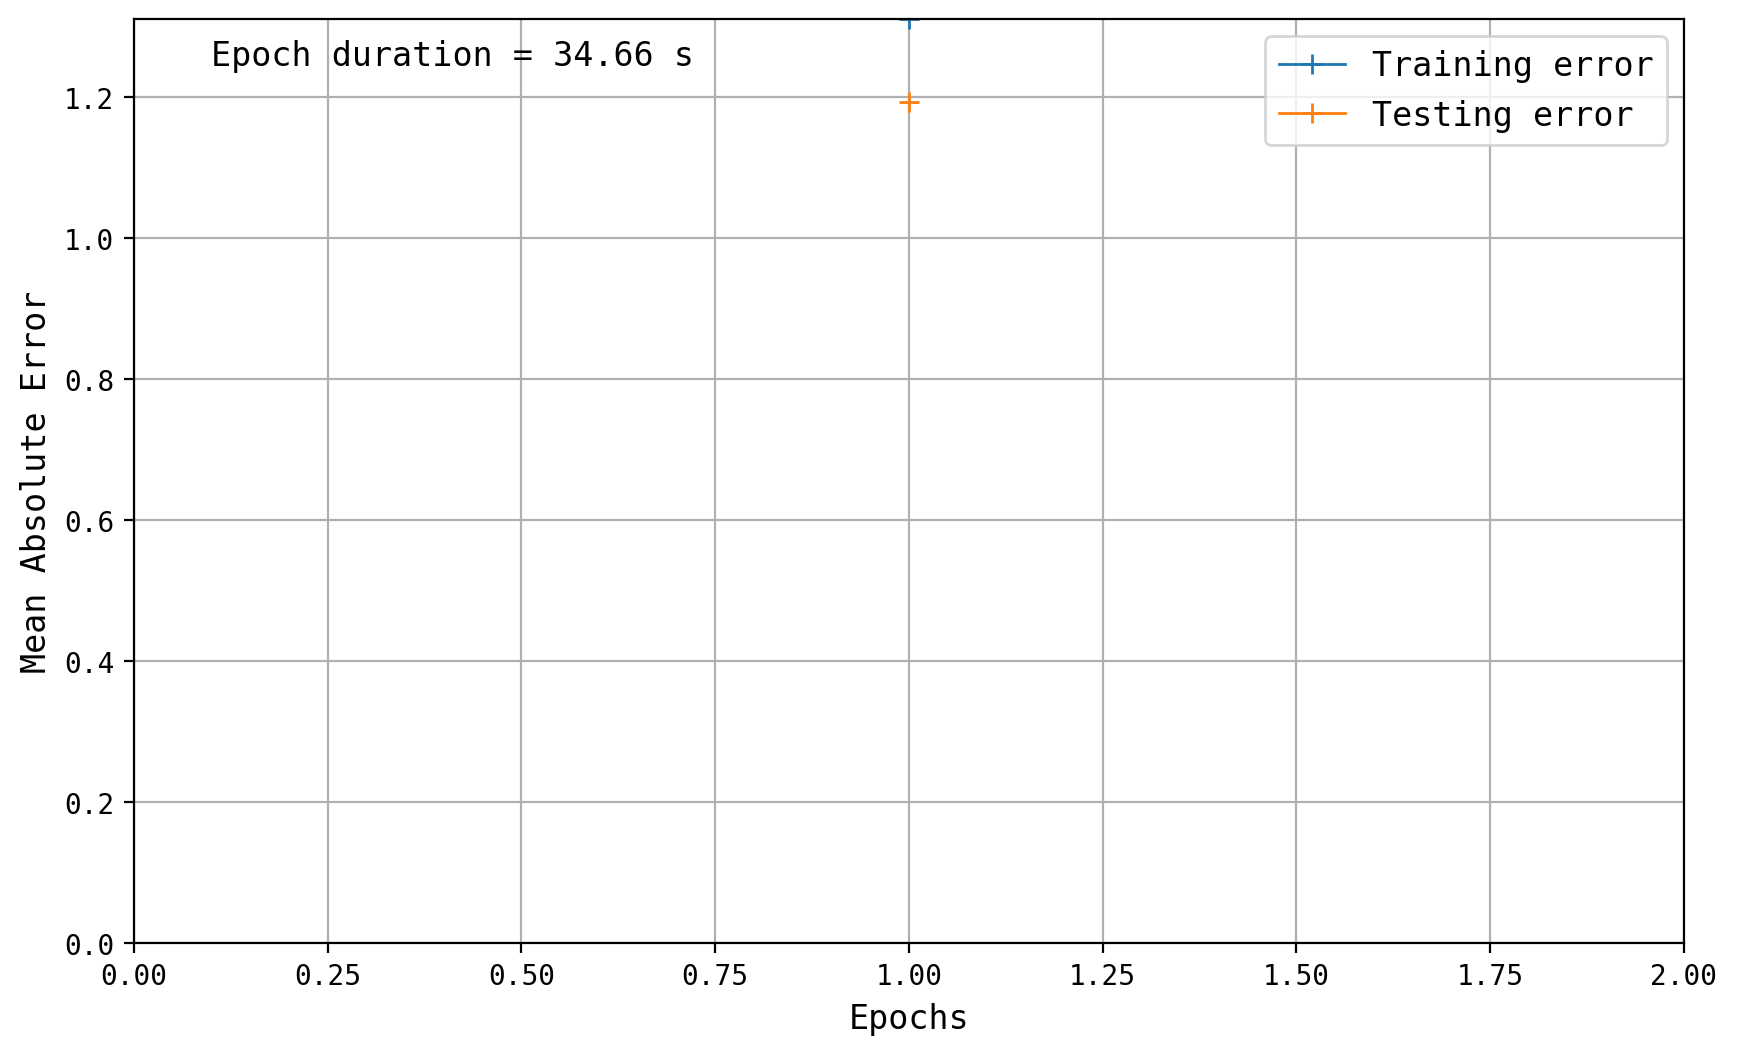

Epoch 2/10:


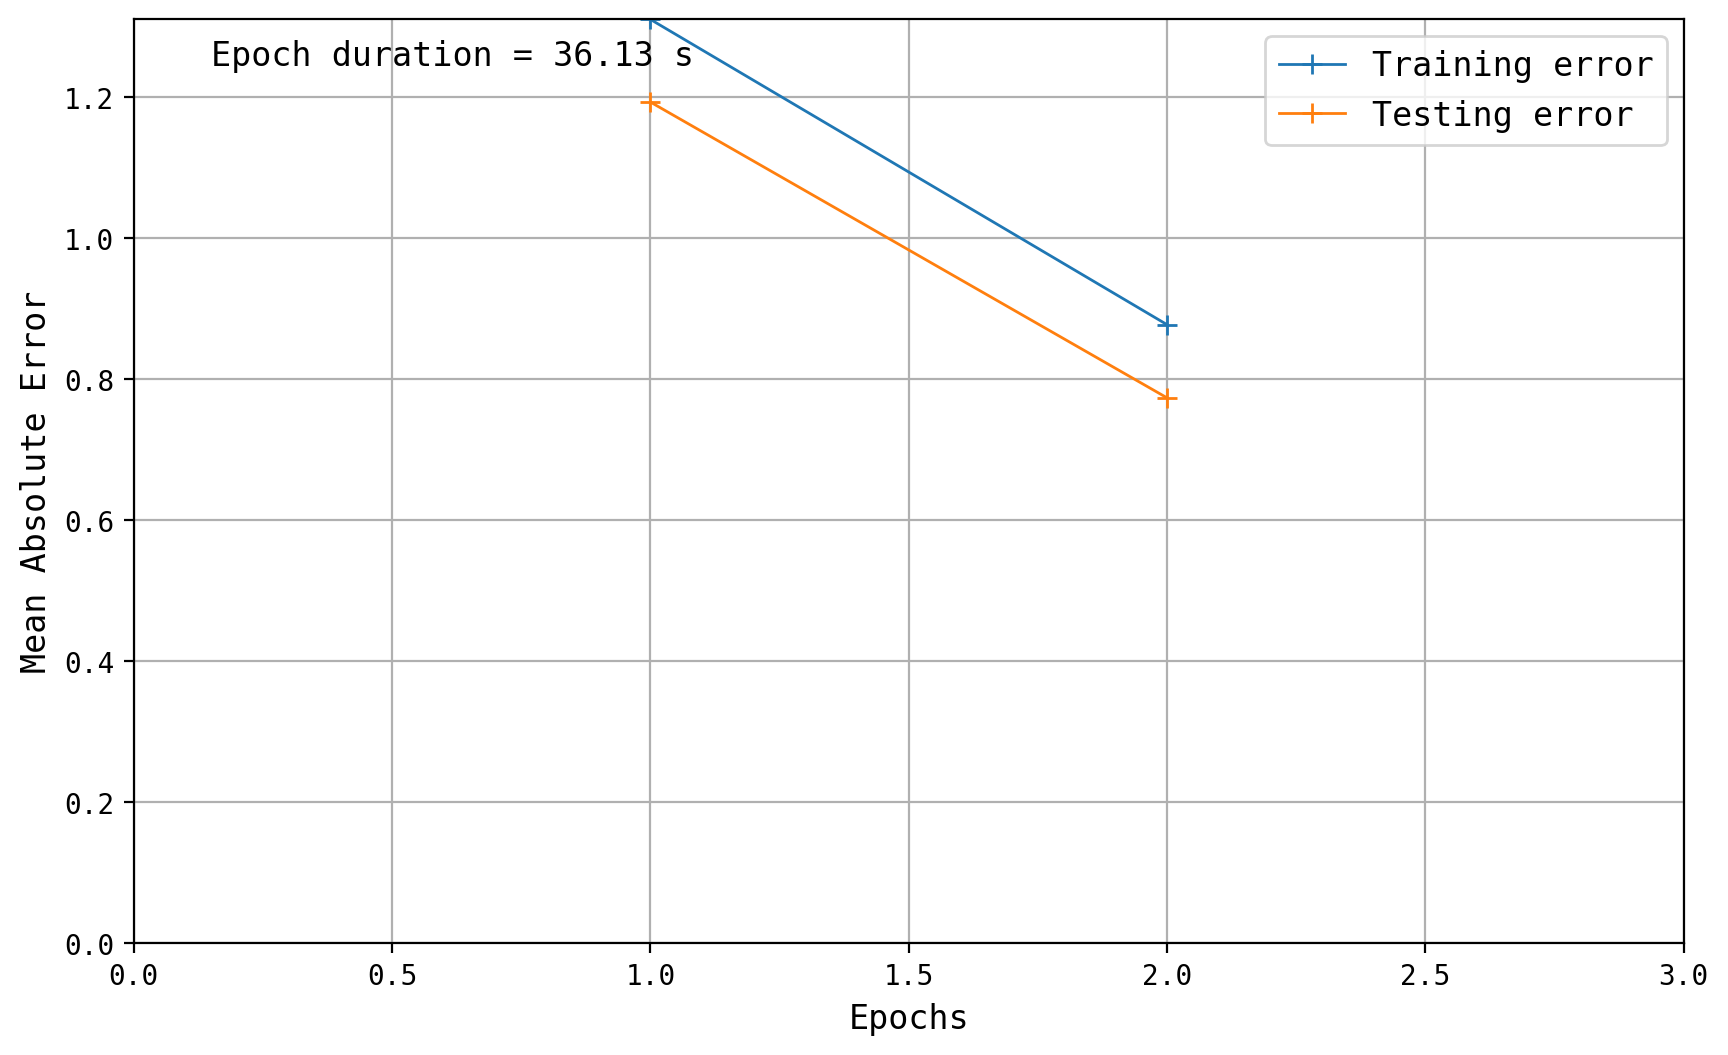

Epoch 3/10:


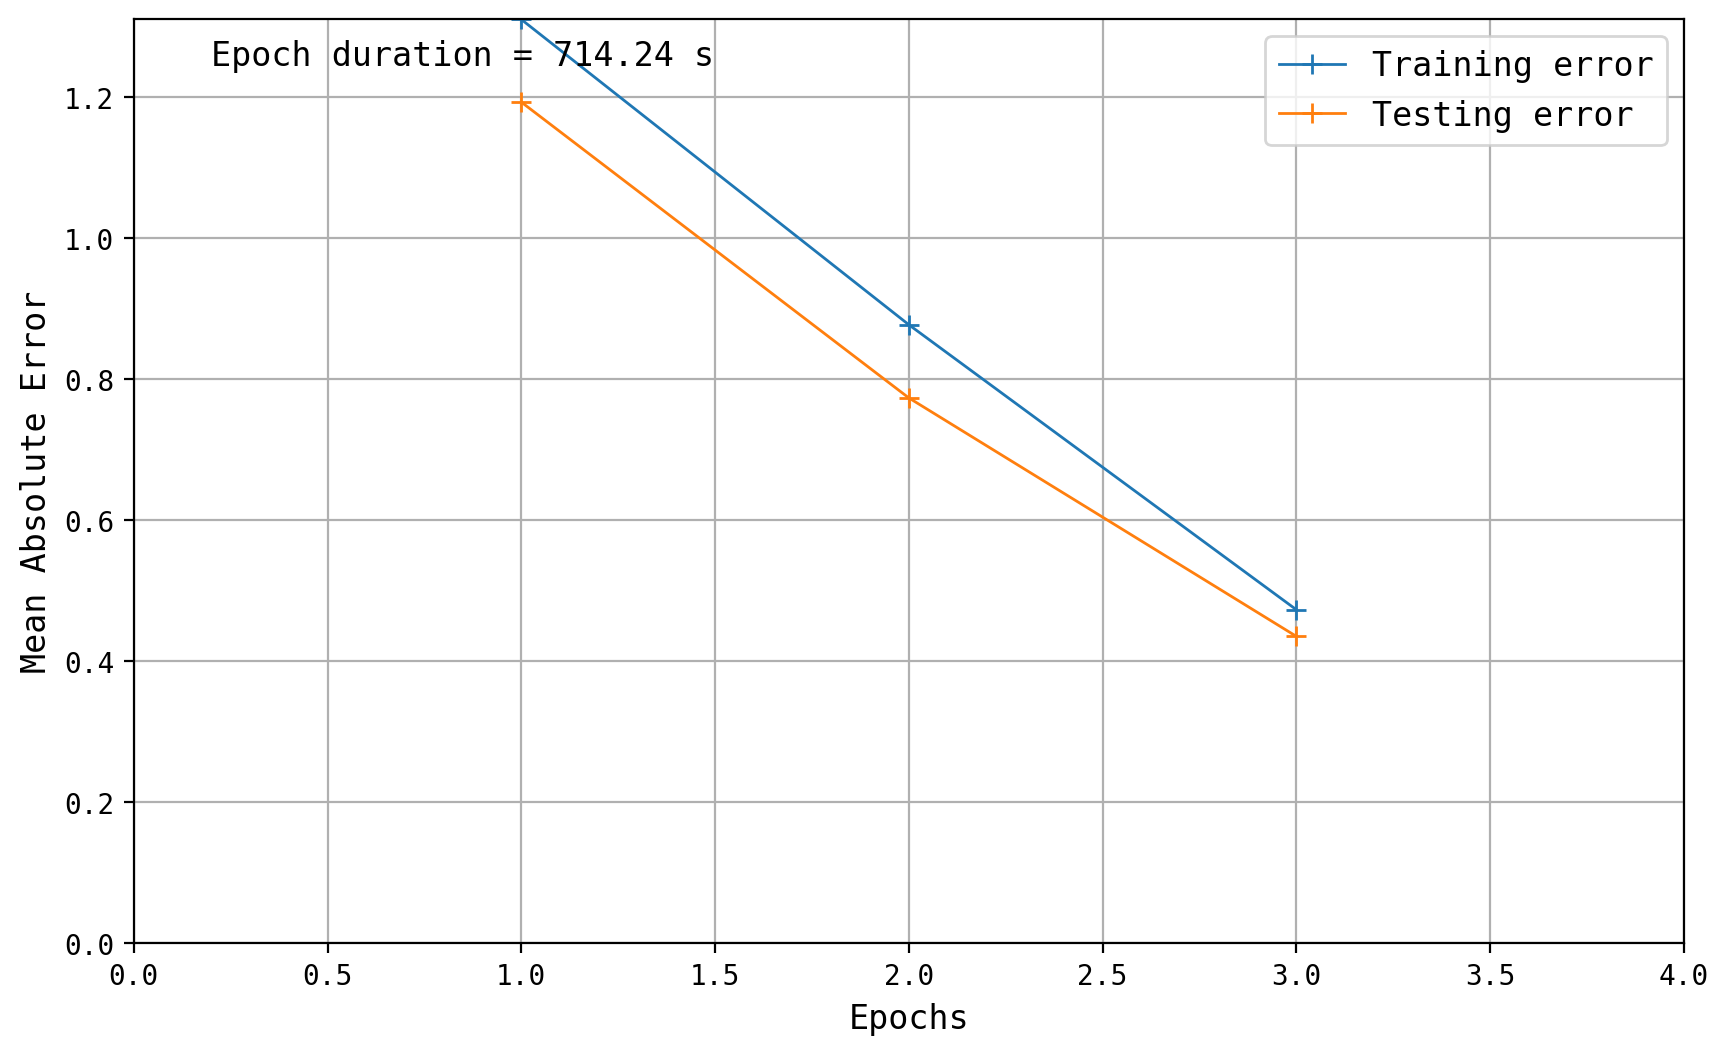

Epoch 4/10:


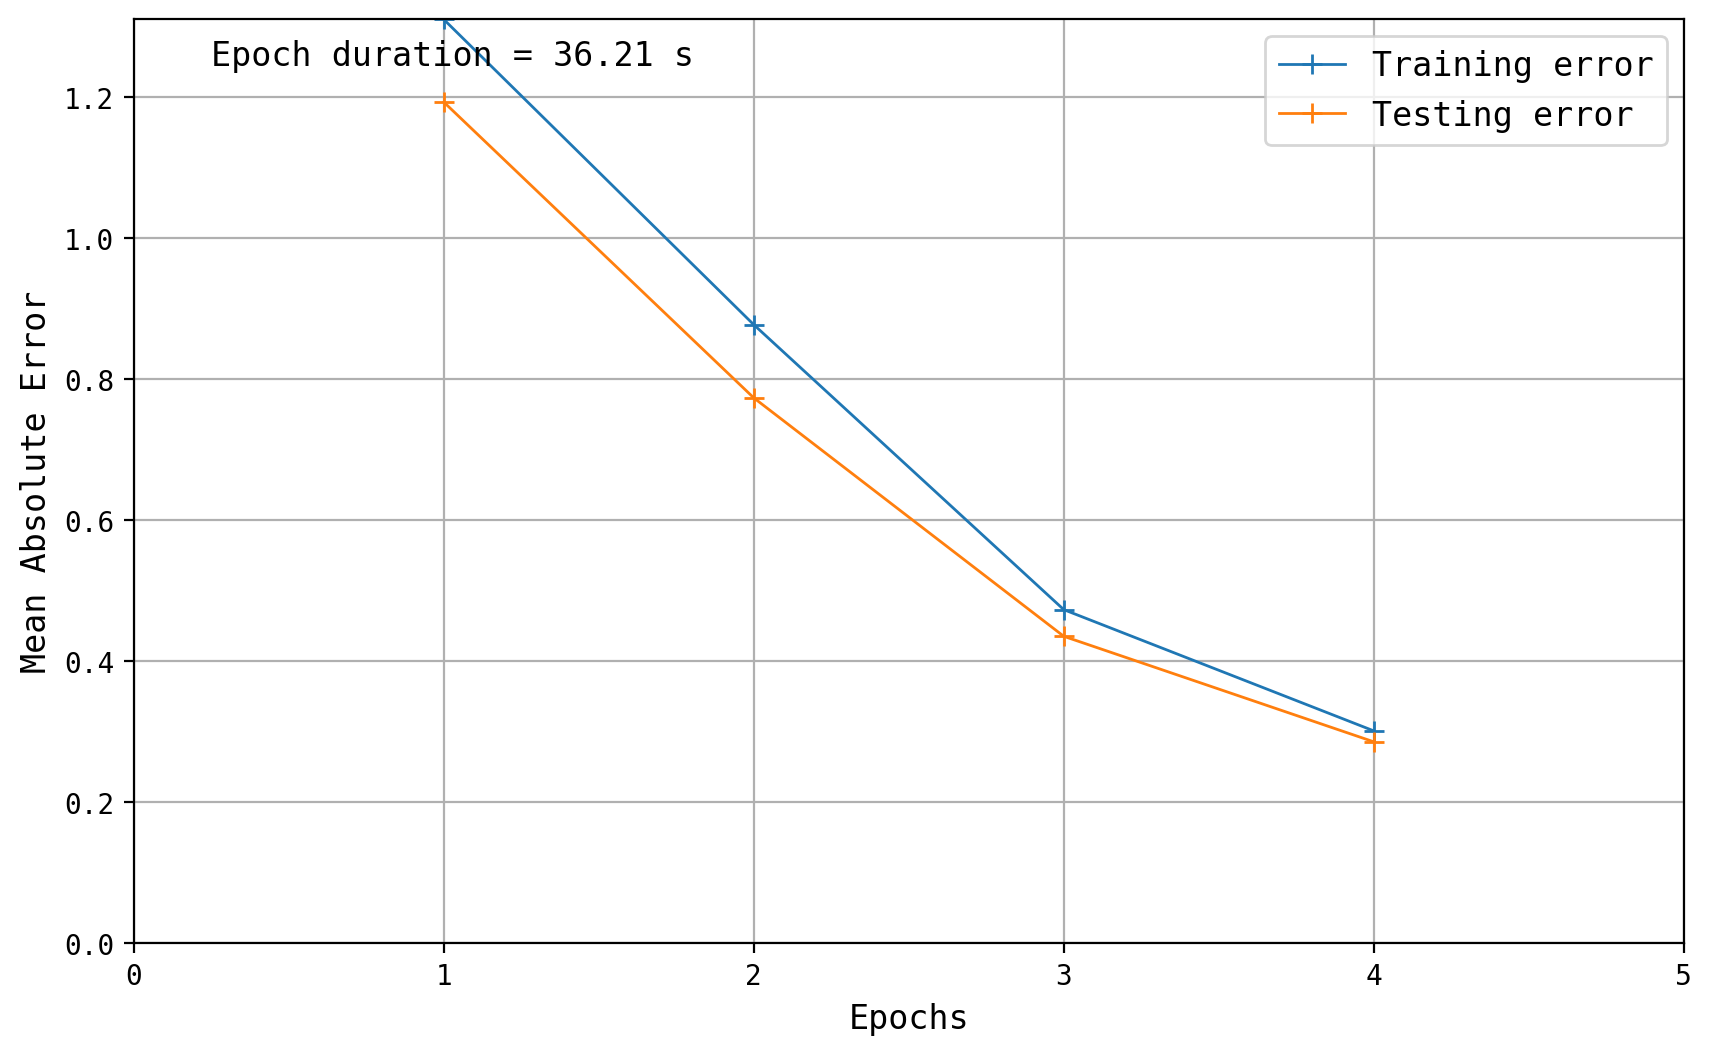

Epoch 5/10:


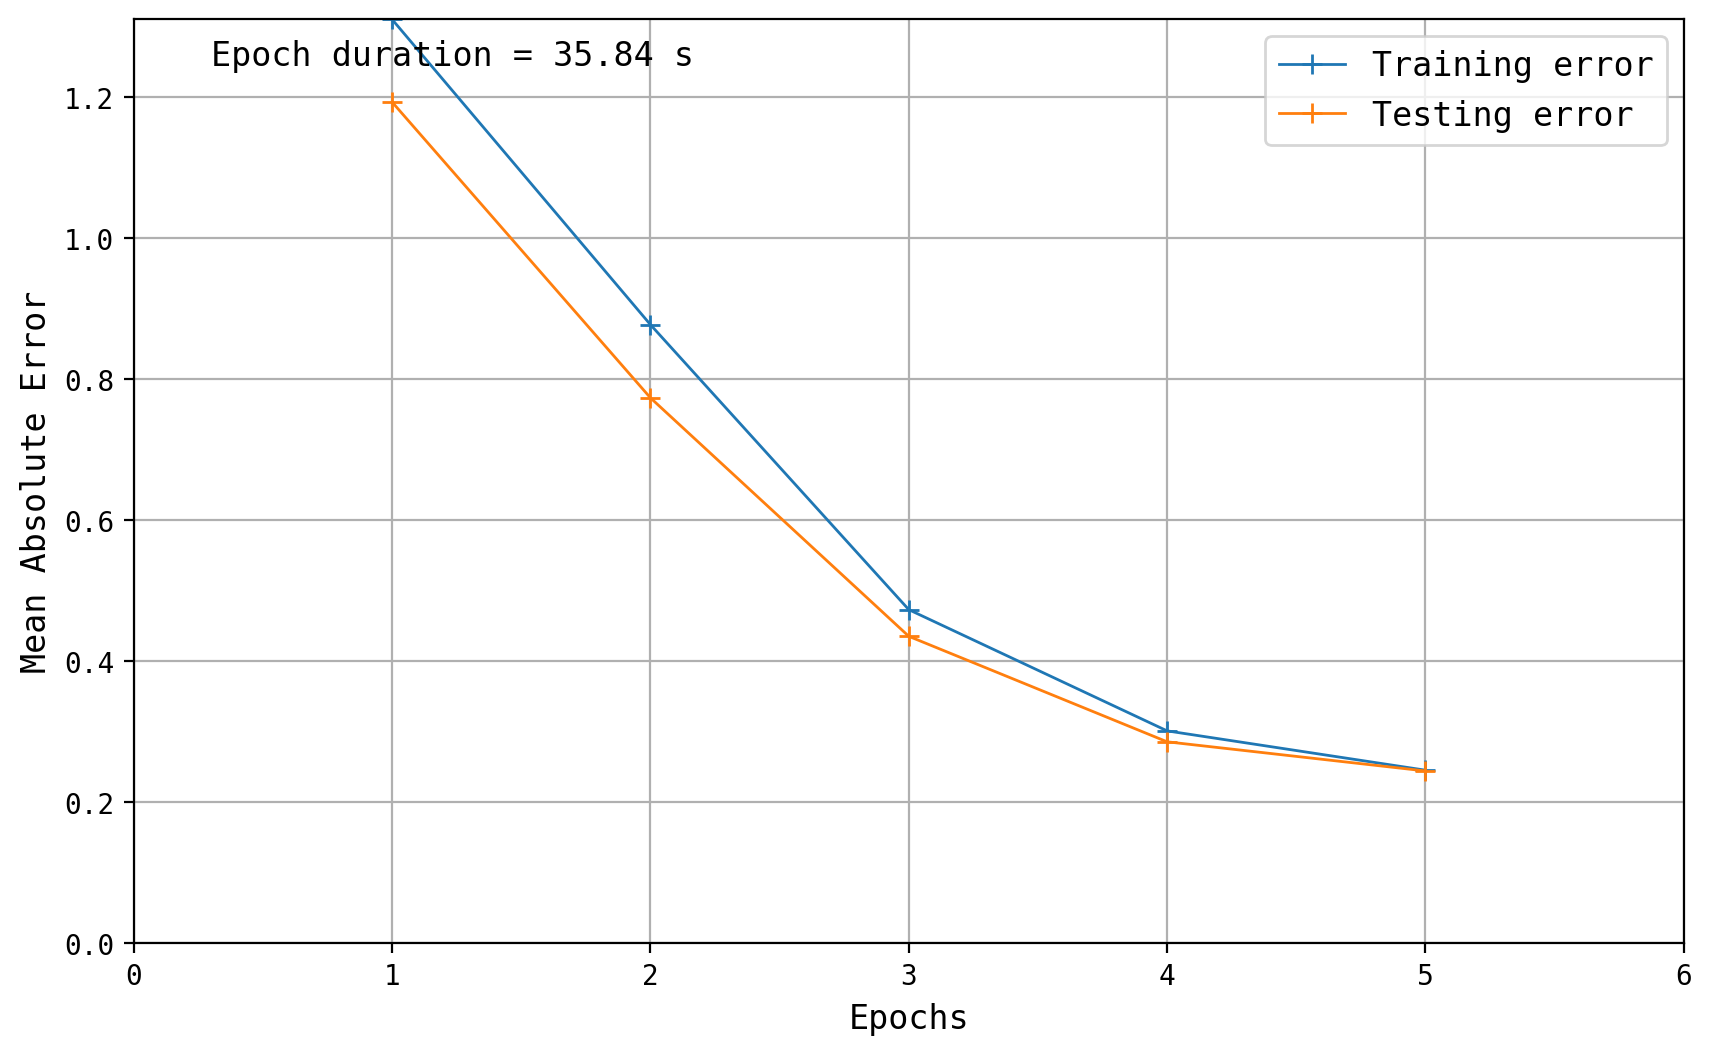

Epoch 6/10:


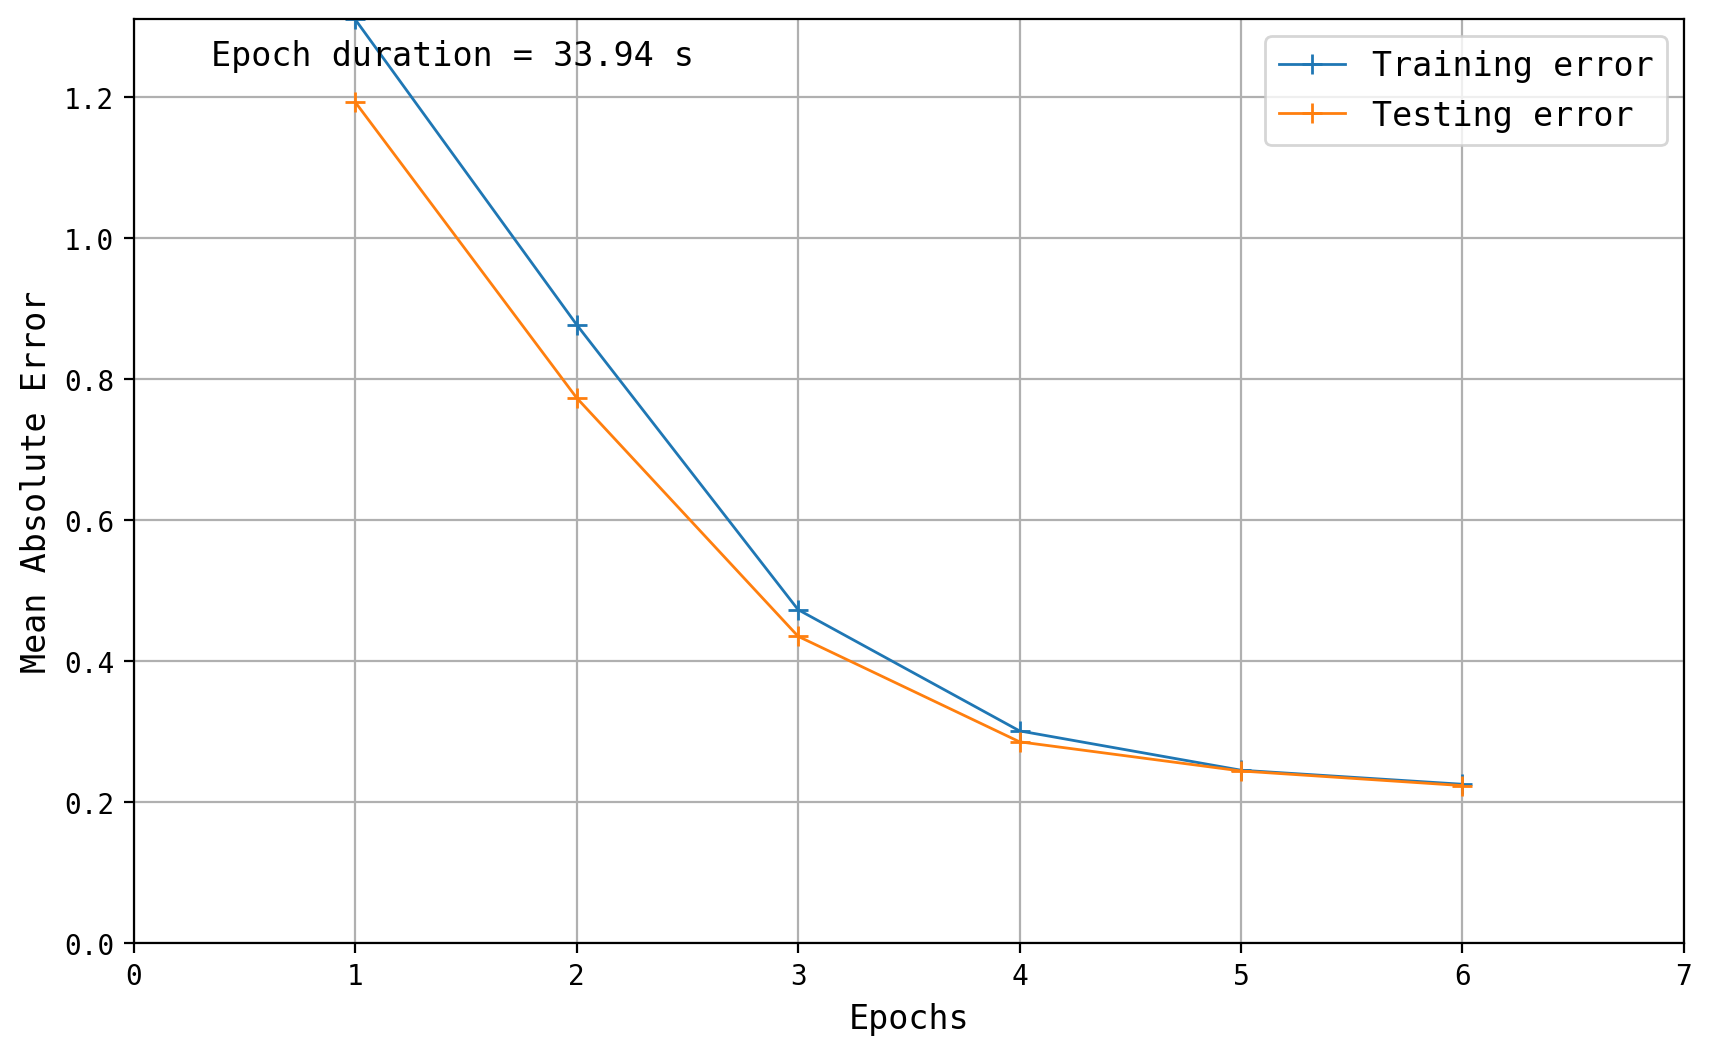

Epoch 7/10:


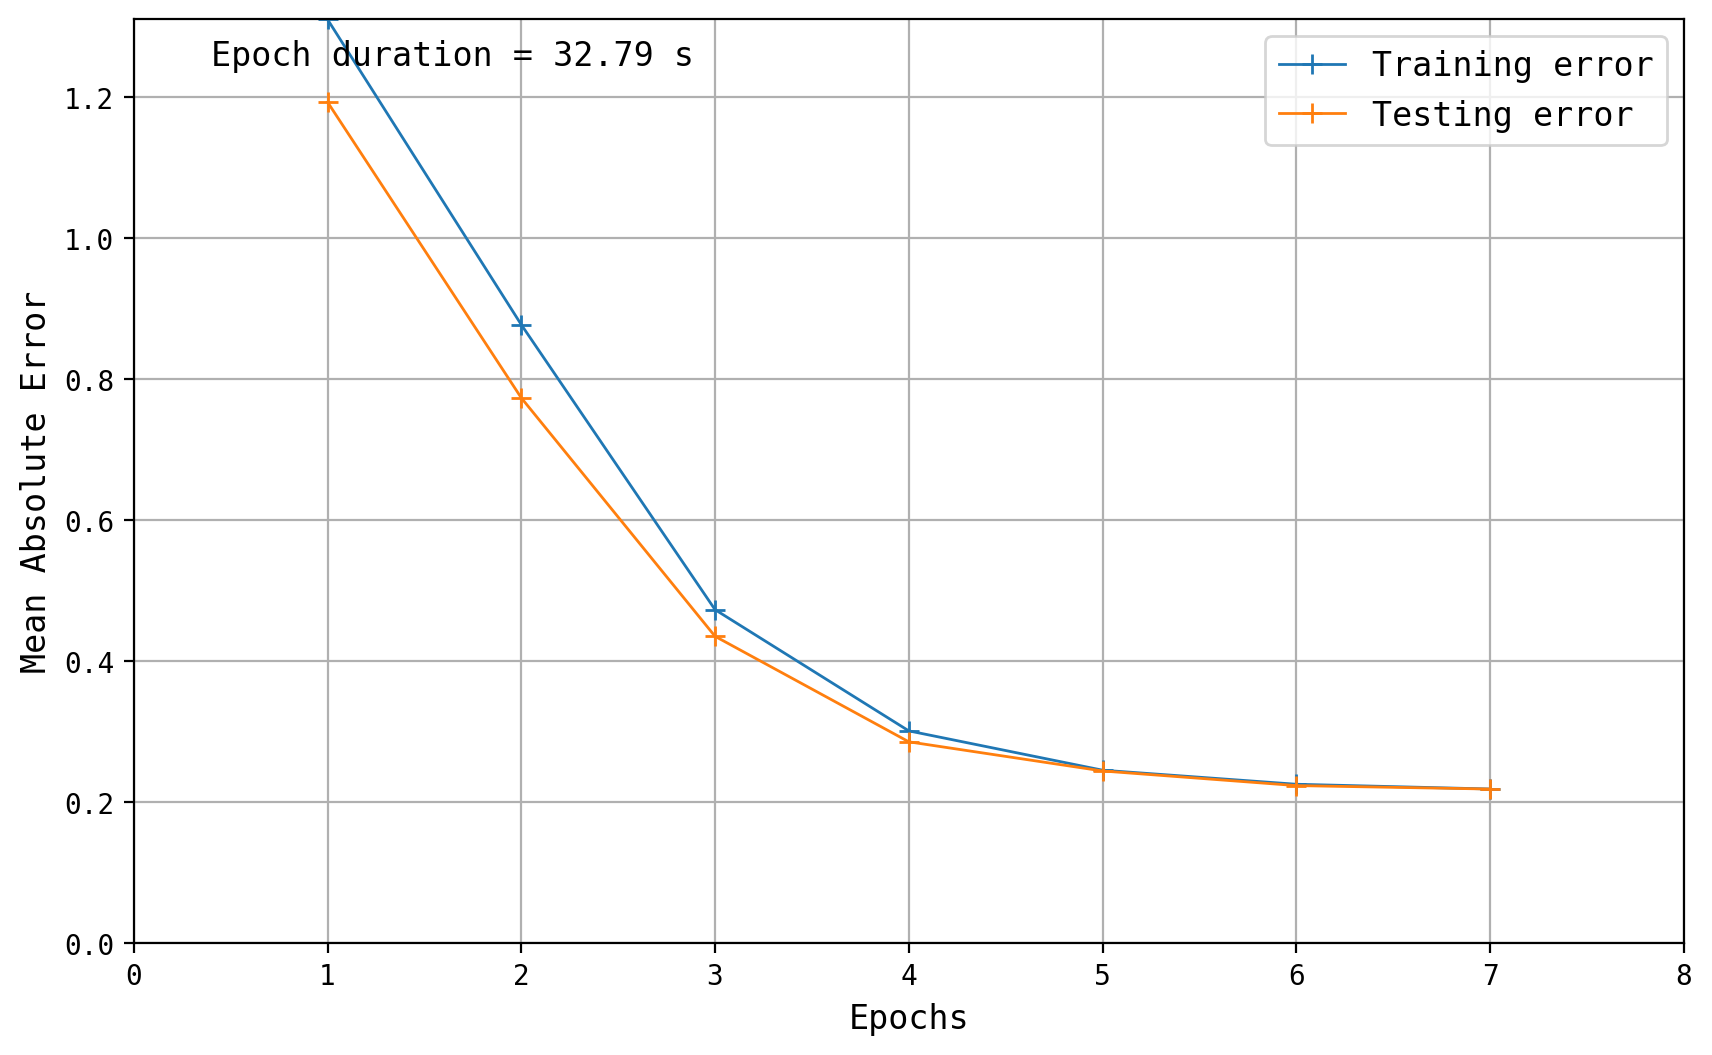

Epoch 8/10:


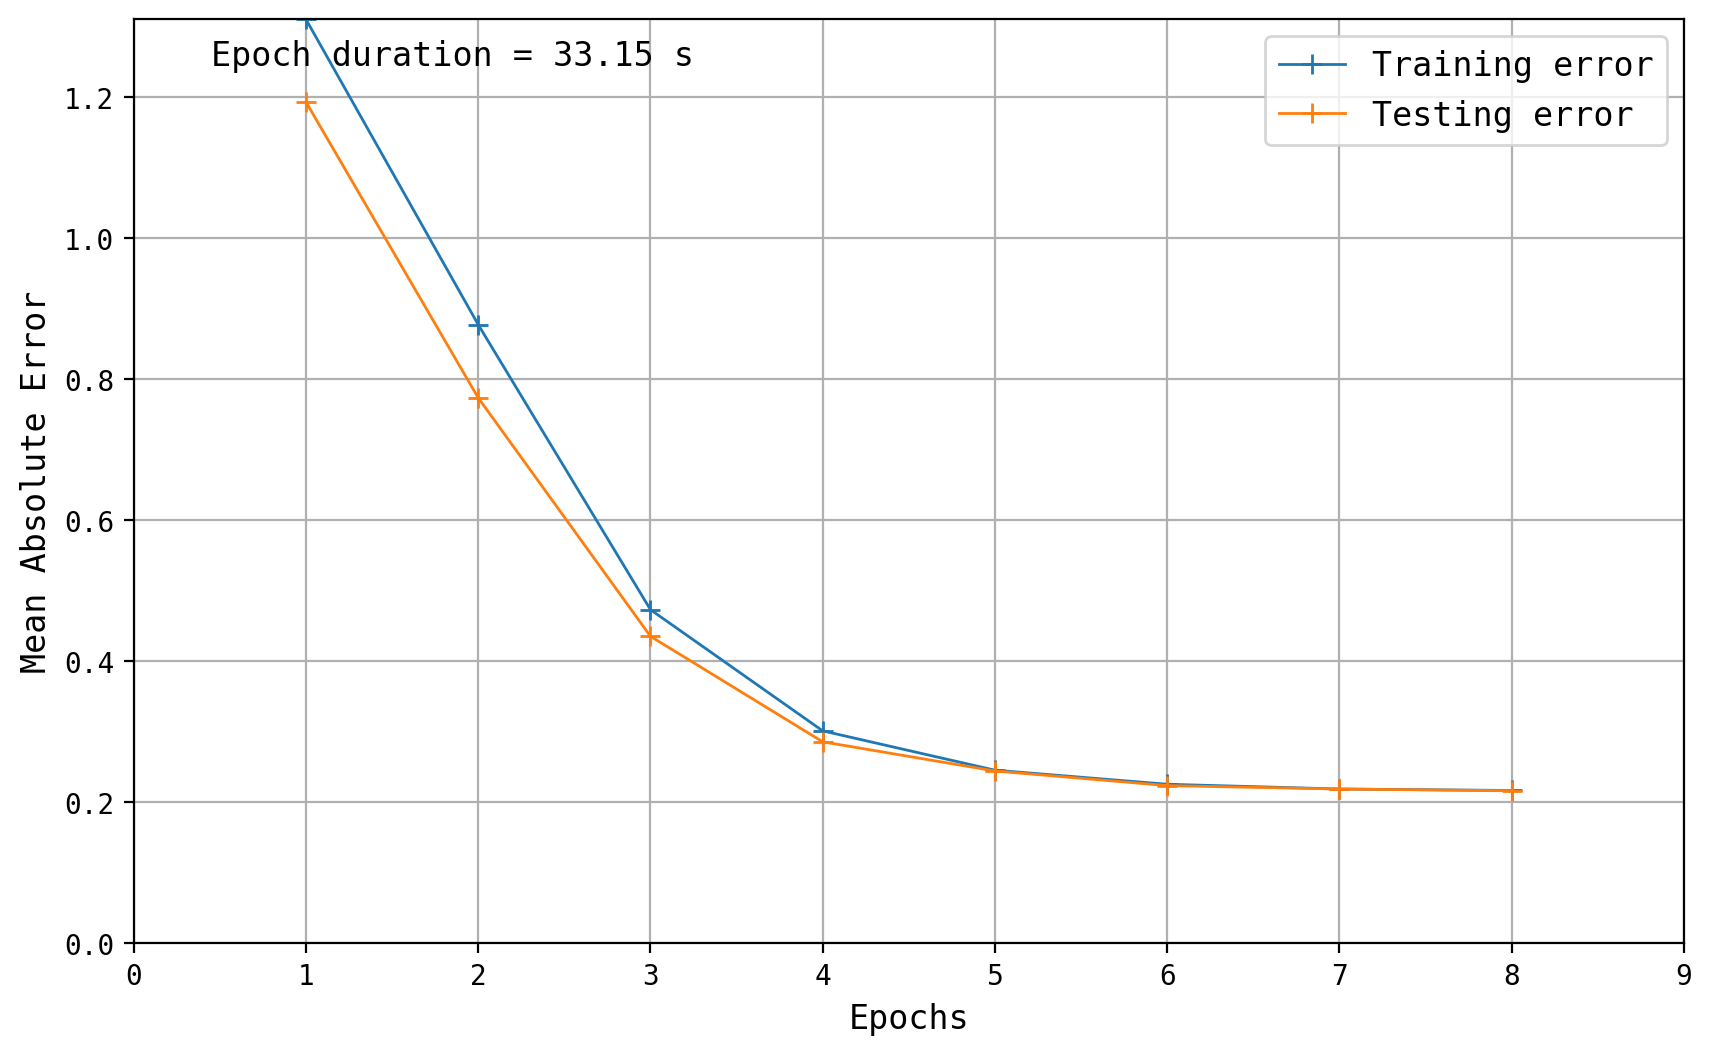

Epoch 9/10:


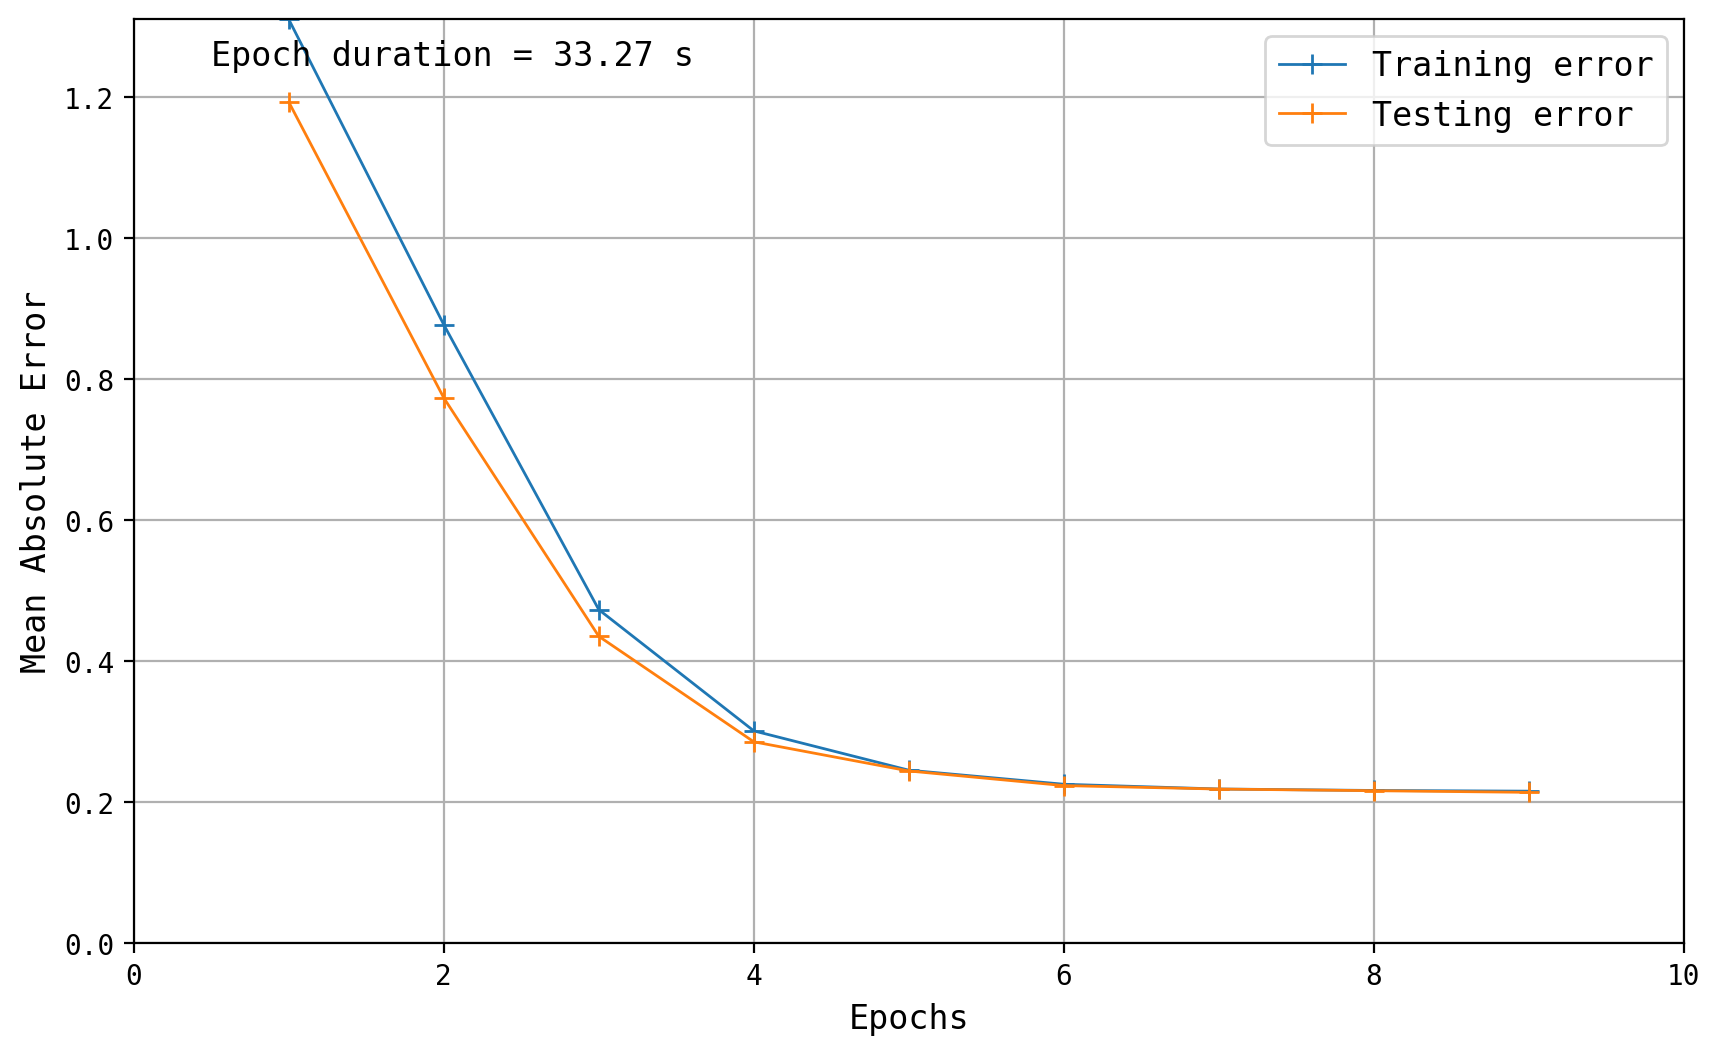

Epoch 10/10:


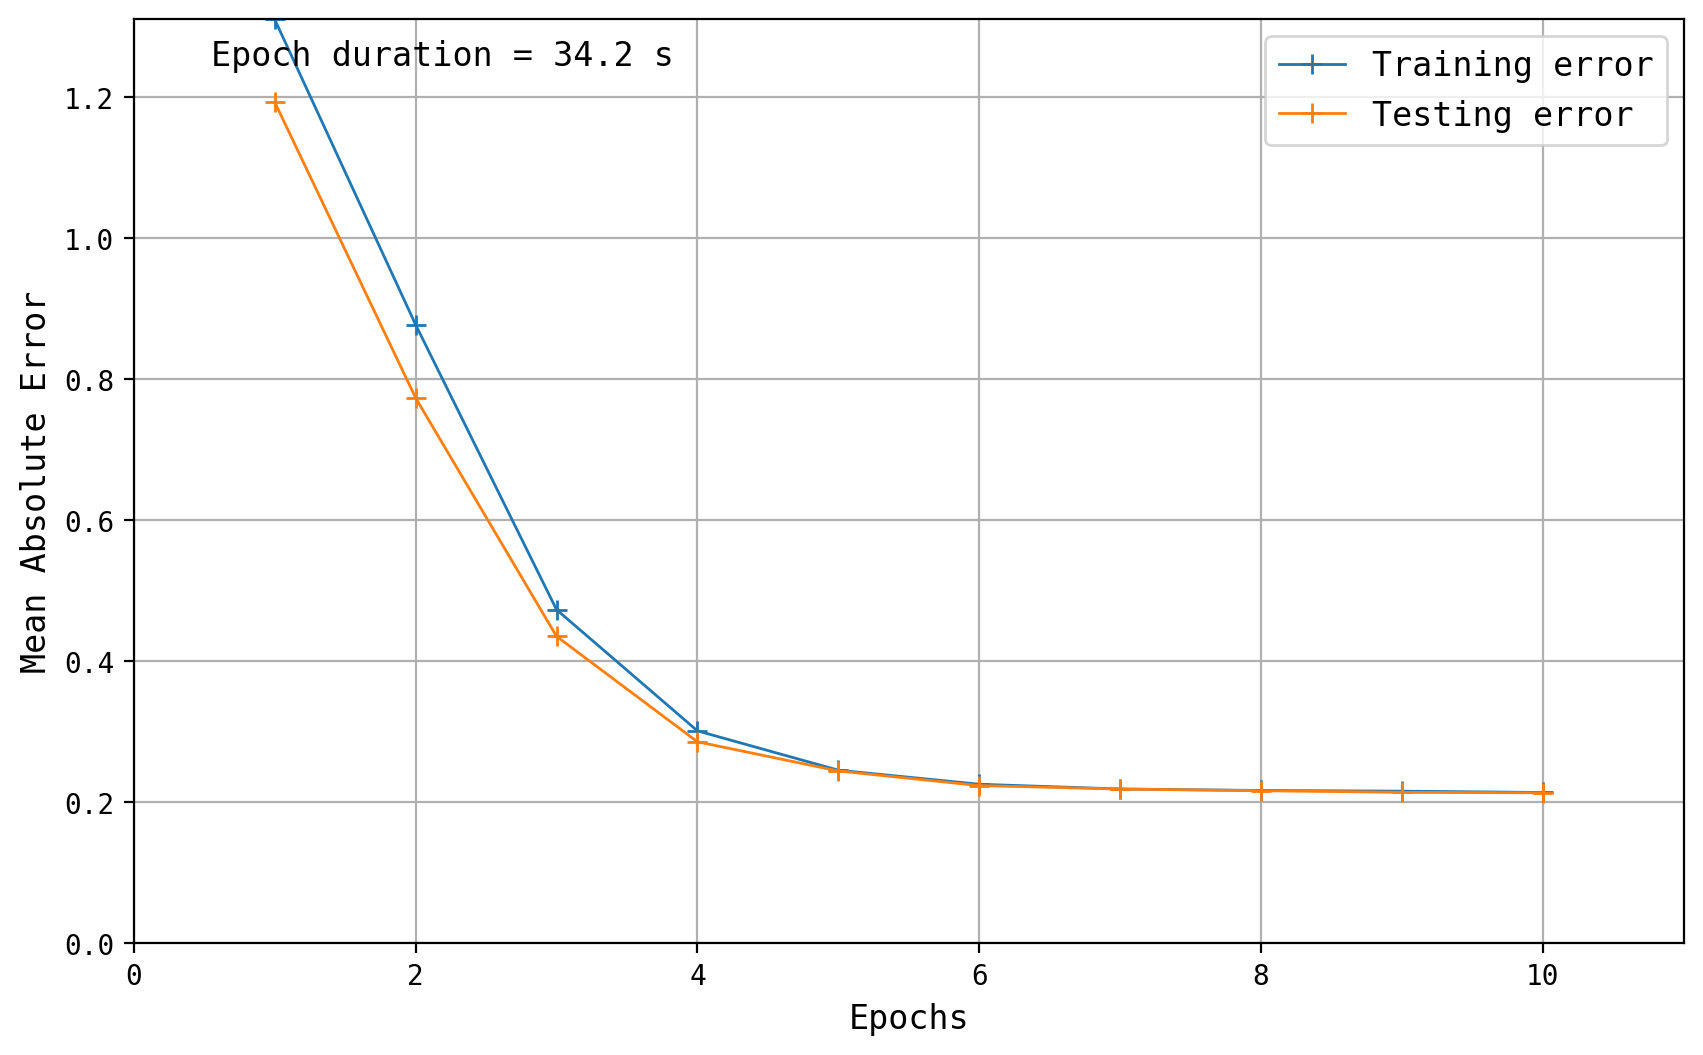

In [ ]:
# training 
# possibility to resume training if Python kernel is active (execute this cell only)

n_epochs = 10

for epoch in range(n_epochs):

    t = time.time()
    training_indicator.append(train_loop(n_files=2, train_loader, model, criterion, optimizer))
    training_time.append(time.time() - t)

    t = time.time()
    testing_indicator.append(test_loop(n_files=2, test_loader, model))
    testing_time.append(time.time() - t)
    print(f"Epoch {epoch + 1}/{n_epochs}:")
    
    plot.learning(training_indicator, testing_indicator, training_time[epoch])

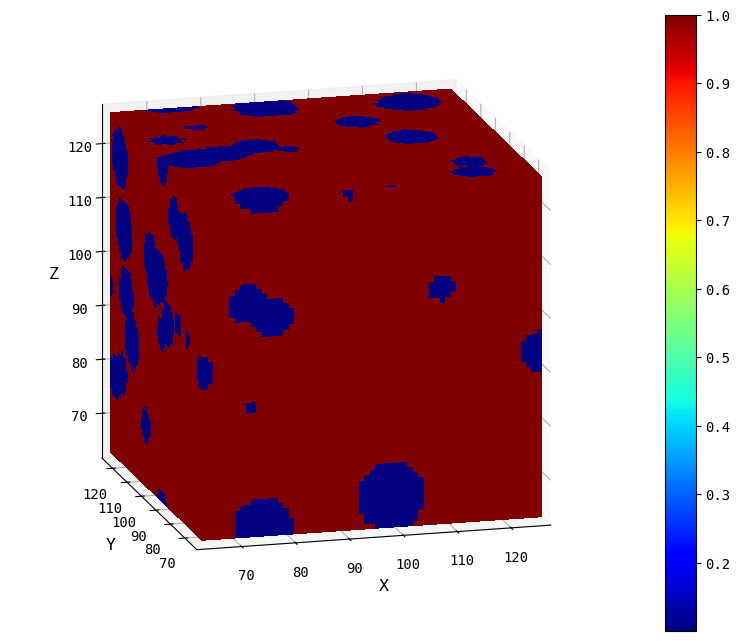

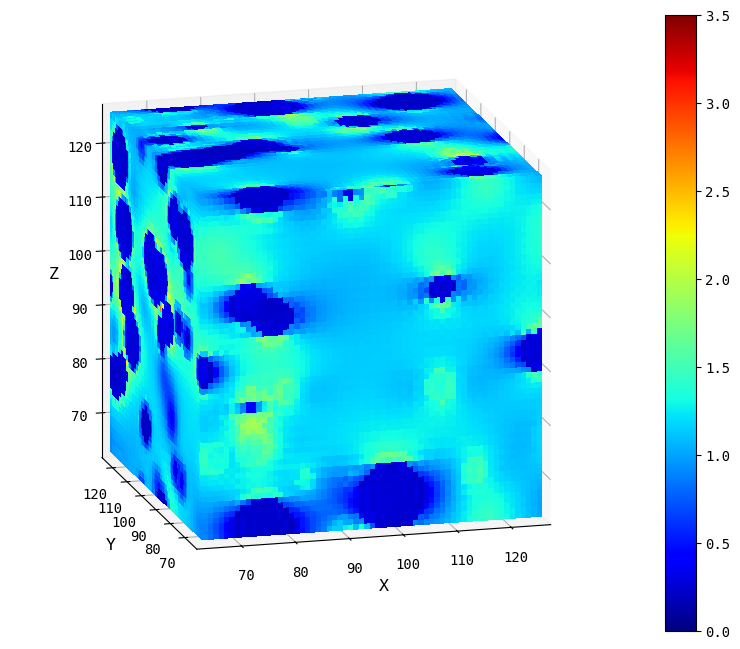

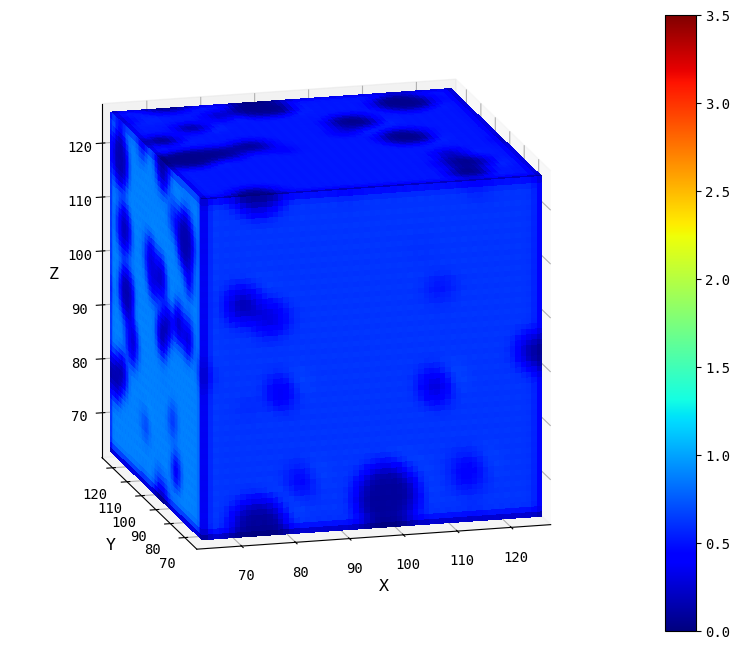

0.2571796774864197


In [ ]:
indicator = torch.zeros((len(test_loader), batch_size))
with torch.no_grad():
    for batch, (data, target) in enumerate(test_loader):
        data, target = data.to(device), target.to(device)
        output = model(data)
        indicator[batch, :] = torch.abs(output - target).mean((1, 2, 3, 4))

index = torch.argmax(indicator)

input = test_loader.dataset[index][0]
target = test_loader.dataset[index][1]
output = model(input.to(device).unsqueeze(0)).detach()

plot.volume(x ,y ,z , input[0, ...])
plot.volume(x ,y ,z , target[0, ...], vmin=0, vmax=3.5)
plot.volume(x ,y ,z , output[0, 0, ...], vmin=0, vmax=3.5)
print(indicator.flatten()[index].item())

In [ ]:
# save model
torch.jit.script(model).save('model_scripted.pt')
torch.save(model.state_dict(), 'model.pt')

In [ ]:
# load model
model = torch.jit.load('model_scripted.pt').to(device)
model.load_state_dict(torch.load('model.pt'))

<All keys matched successfully>